In [1]:
# import modules
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA

import graphviz
from dtreeviz.trees import *

### Importing a numeric DF for labeled Helix mtDB
### NOTE: When labeling a base, variants that are more numerous than known pathogenic variants were considered not pathogenic

- codon position 3 & log_hom > 11 = "no"
- codon position 2 & log_hom > 8.5 = "no"
- codon position 1 & log_hom > 11 = "no"
- annotation == "rRNA" & log_hom > 11 = "no"
- annotation == "anticodon" = "yes"
- mutation == "in-del" log_hom > 5 == "no" 
- mutation == "in-del" & log_het > 5 = "no"
- mutation == "transition" & log_hom > 11 = "no"
- mutation == "transversion" & log_het > 2.85 = "no"
- mutation == "transversion" & log_hom >= 8.08 = "no"

In [2]:
numericDF = pd.read_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/numPathKnown.csv')
numericDF.head(5)

,base,gene,annotation,counts_hom,counts_het,pathogenic,mutation,log_hom,log_het
0,593,MT-TF,8,480.0,41.000,2,2,6.173786,3.713572
1,593,MT-TF,8,86.0,0.001,2,1,4.454347,-6.907755
2,593,MT-TF,8,9.0,0.001,2,3,2.197225,-6.907755
3,593,MT-TF,8,37.0,3.000,2,3,3.610918,1.098612
4,606,MT-TF,8,1.0,0.001,2,3,0.000000,-6.907755


### Decision Trees

#### This is the numeric data frame without the log transformed columns

In [3]:
treeDF = numericDF.drop(columns = ['log_hom', 'log_het'])
treeDF.head(10)

,base,gene,annotation,counts_hom,counts_het,pathogenic,mutation
0,593,MT-TF,8,480.000,41.000,2,2
1,593,MT-TF,8,86.000,0.001,2,1
2,593,MT-TF,8,9.000,0.001,2,3
3,593,MT-TF,8,37.000,3.000,2,3
4,606,MT-TF,8,1.000,0.001,2,3
5,606,MT-TF,8,63.000,3.000,2,2
6,608,MT-TF,8,0.001,1.000,2,2
7,611,MT-TF,4,0.001,1.000,2,1
8,616,MT-TF,8,0.001,6.000,2,2
9,618,MT-TF,8,0.001,1.000,2,2


In [4]:
treeDF.pathogenic.value_counts() #2 = pathogenic == 'yes'

2    852
1     82
Name: pathogenic, dtype: int64

In [134]:
X_train, X_test, y_train, y_test = train_test_split(treeDF.drop(['base', 'gene', 'pathogenic'], axis = 1), treeDF.loc[:, 'pathogenic'], test_size=0.20, random_state=0)

In [135]:
helix_tree = DecisionTreeClassifier(random_state = 0, min_samples_leaf=5)
helix_tree.fit(X_train,y_train)
score="{:.2f}".format(helix_tree.score(X_test,y_test)) #this is the test score!? Must be overfitting
print(score)

0.97


In [136]:
print(y_train.value_counts())
y_test.value_counts()

2    681
1     66
Name: pathogenic, dtype: int64


2    171
1     16
Name: pathogenic, dtype: int64

### Balancing the dataset by randomly sampling an equivalent number of pathogenic mutations (82) as non-pathogenic

In [137]:
### making a new DF where 'pathogenic' == 'yes'
yesDF = treeDF[treeDF['pathogenic']==2]
print('Yes: ', yesDF.pathogenic.value_counts())

###extracting the rows where 'pathogenic' == 'no'
noDF = treeDF[treeDF['pathogenic']==1]
print('No: ', noDF.pathogenic.value_counts())

Yes:  2    852
Name: pathogenic, dtype: int64
No:  1    82
Name: pathogenic, dtype: int64


In [138]:
### sampling 82rows for 'pathogenic' == 'yes'
yesSample = yesDF.sample(n=82, random_state=13)
yesSample.head(10)

,base,gene,annotation,counts_hom,counts_het,pathogenic,mutation
561,9966,MT-CO3,1,1092.000,29.000,2,2
273,4659,MT-ND2,1,0.001,1.000,2,3
607,12015,MT-ND4,2,6.000,4.000,2,2
348,6307,MT-CO1,2,1.000,0.001,2,3
756,15451,MT-CYB,3,12.000,3.000,2,2
321,5780,MT-TC,8,162.000,0.001,2,2
831,185,MT-CRb,5,21.000,0.001,2,1
729,14831,MT-CYB,1,571.000,41.000,2,2
109,2158,MT-RNR2,7,1871.000,9.000,2,2
21,745,MT-RNR1,7,0.001,1.000,2,1


### Combining selections into a single DF

In [139]:
balancedDF = pd.concat([yesSample, noDF])
balancedDF.pathogenic.value_counts()

2    82
1    82
Name: pathogenic, dtype: int64

### Building a decision tree with balanced classes

In [140]:
X_train, X_test, y_train, y_test = train_test_split(balancedDF.drop(['base', 'gene', 'pathogenic'], axis = 1), balancedDF.loc[:, 'pathogenic'], test_size=0.25, random_state=13)

In [141]:
balanced_tree = DecisionTreeClassifier(random_state = 0, min_samples_leaf=5)
balanced_tree.fit(X_train,y_train)
score="{:.2f}".format(balanced_tree.score(X_test,y_test)) #this is the test score!?
print(score)

0.80


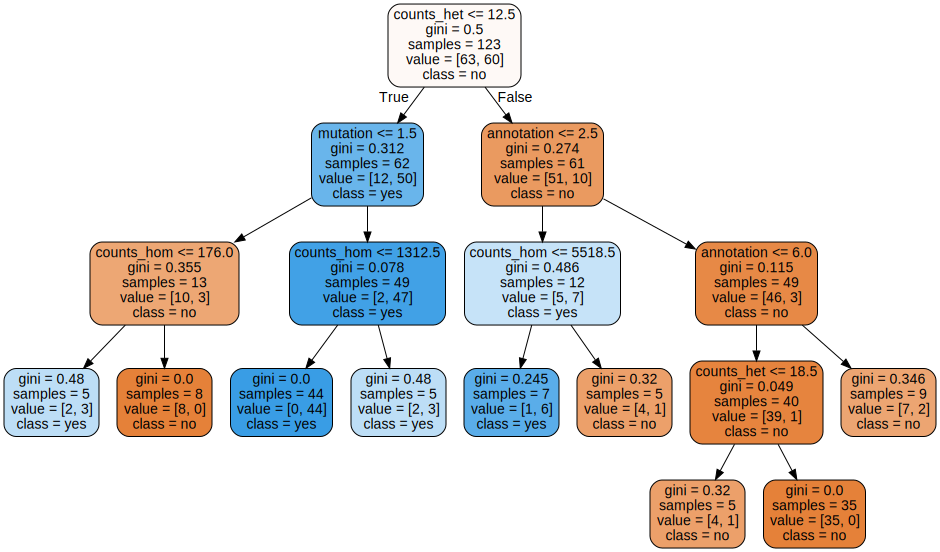

In [17]:
viz = tree.export_graphviz(balanced_tree,
                                feature_names= X_test.columns,
                                class_names = ['no', 'yes'], filled=True, rounded=True)
graph = graphviz.Source(viz, format="png")
graph

In [19]:
graph.render("full_balanced_tree_graphivz")

'full_balanced_tree_graphivz.png'

### A function to repeatedly sample 'yes' instances, build a tree, and output a score

In [142]:
def build_balanced_tree(yesDF, noDF, numSamples, numTrees):
    # yesDF - the dataframe of all pathogenic == 'yes'
    # noDF - the dataframe of all pathogenic == 'no'
    # numSamples - the number of either 'yes' or 'no' rows to sample from the DF with more rows
    # numTrees - the number of trees to build
            
    # making an array to hold the scores
    scores = np.zeros(numTrees, dtype = float)
    
    for i in range(numTrees):
        sampleDF = yesDF.sample(n=numSamples)
        balancedDF = pd.concat([sampleDF, noDF])
    
        X_train, X_test, y_train, y_test = train_test_split(balancedDF.drop(['base', 'gene', 'pathogenic'], axis = 1),
                                                        balancedDF.loc[:, 'pathogenic'], test_size=0.25)
    
        balanced_tree = DecisionTreeClassifier(min_samples_leaf=5)
        balanced_tree.fit(X_train,y_train)
    
        score="{:.2f}".format(balanced_tree.score(X_test,y_test))
        
        scores[i] = score
    
    print('Mean score: ', "{:.2f}".format(scores.mean()), 'Std dev: ', "{:.2f}".format(scores.std(ddof=1)))
        

In [143]:
build_balanced_tree(yesDF, noDF, 82, 1000)

Mean score:  0.90 Std dev:  0.06


### Need to use cost-complexity pruning - doing so here without setting min_samples_leaf

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

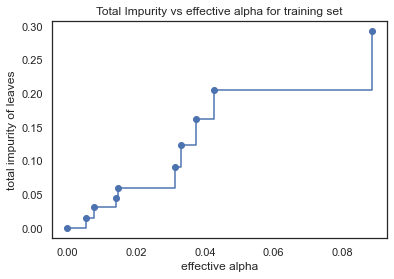

In [145]:
prunedTree = DecisionTreeClassifier(random_state=0)
path = prunedTree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [146]:
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
trees[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.20640052397609016


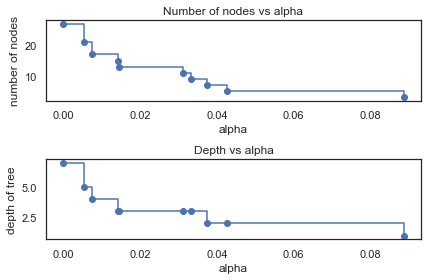

In [147]:
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Looks like alpha = 0.03 might give the most interpretable tree with the highest test accuracy

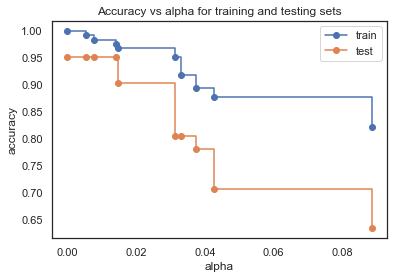

In [148]:
train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
drawstyle="steps-post")
ax.legend()
plt.show()

In [149]:
pruned_balanced_tree = DecisionTreeClassifier(random_state = 0, ccp_alpha=0.03)
pruned_balanced_tree.fit(X_train,y_train)
score="{:.2f}".format(pruned_balanced_tree.score(X_test,y_test)) #this is the test score!?
print(score)

0.90


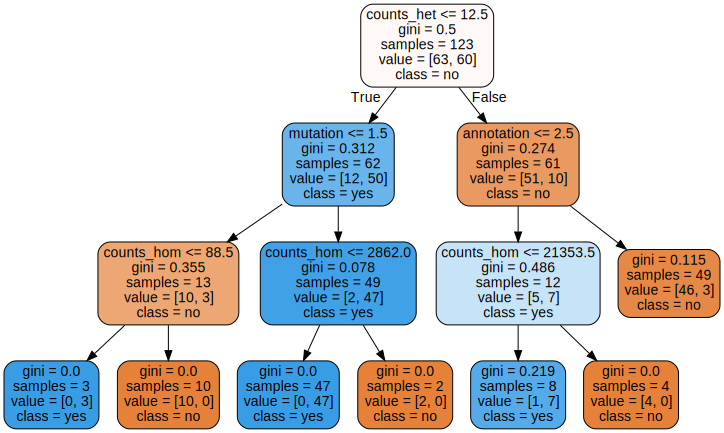

In [152]:
viz = tree.export_graphviz(pruned_balanced_tree,
                                feature_names= X_test.columns,
                                class_names = ['no', 'yes'], filled=True, rounded=True)
graph = graphviz.Source(viz, format="png")
graph

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


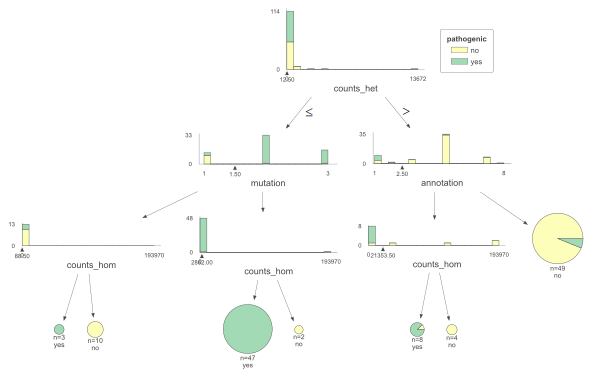

In [153]:
dtviz = dtreeviz(pruned_balanced_tree, X_train, y_train, target_name="pathogenic", feature_names= X_test.columns,
                class_names=['no', 'yes'])
dtviz

In [25]:
graph.render("pruned_balanced_tree")

'pruned_balanced_tree.png'

In [26]:
dtviz.save("/Users/leekapp/Desktop/CS254/Assignments/FinalProject/prunedBalancedTrainTree.svg")

### Testing ensemble methods alongside logistic regression and SVM with 100 Replicates
I've based this code on a course in Machine Learning Technologies at the University of Southampton, UK https://tdgunes.com/COMP6246-2019Fall/lab3_solution/index.html
 

In [154]:
def test_clfs(*clfs): # clf -> classifier
    for clf in clfs:
        # making an array to hold the scores
        accuracy_scores = np.zeros(100, dtype = float)
        
        # making new train-test splits from balanced DFs sampled original yes/no DFs
        for i in range(100):
            sampleDF = yesDF.sample(n=82)
            balancedDF = pd.concat([sampleDF, noDF])
            X_train, X_test, y_train, y_test = train_test_split(balancedDF.drop(['base', 'gene', 'pathogenic'], axis = 1),
                                                        balancedDF.loc[:, 'pathogenic'], test_size=0.25)
            clf.fit(X_train, y_train) # train the classifier
            y_pred = clf.predict(X_test)
        
            score="{:.2f}".format(accuracy_score(y_test, y_pred)) # add accuracy score to the scores array
            accuracy_scores[i] = score
 
        print(clf.__class__.__name__ + "  Mean Accuracy:","{:.2f}".format(accuracy_scores.mean()), 
        clf.__class__.__name__ + "  Std dev:", "{:.2f}".format(accuracy_scores.std(ddof=1)))

### Using cost-complexity pruning in random forest as with individual tree, alpha = 0.03

#### Hard voting

In [155]:
log_clf = LogisticRegression(solver='liblinear', max_iter=100, random_state=0)
rnd_clf = RandomForestClassifier(random_state=0, ccp_alpha= 0.03)
svm_clf = SVC(random_state=0, probability=True)
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard') # hard voting
test_clfs(log_clf, rnd_clf, svm_clf, voting_clf)

LogisticRegression  Mean Accuracy: 0.75 LogisticRegression  Std dev: 0.07
RandomForestClassifier  Mean Accuracy: 0.93 RandomForestClassifier  Std dev: 0.05
SVC  Mean Accuracy: 0.56 SVC  Std dev: 0.06
VotingClassifier  Mean Accuracy: 0.76 VotingClassifier  Std dev: 0.08


#### Soft voting

In [36]:
log_clf_s = LogisticRegression(solver='liblinear', max_iter=100, random_state=0)
rnd_clf_s = RandomForestClassifier(random_state=0, ccp_alpha= 0.03)
svm_clf_s = SVC(random_state=0, probability=True)
voting_clf_s = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft') # soft voting
test_clfs(log_clf_s, rnd_clf_s, svm_clf_s, voting_clf_s)

LogisticRegression  Mean Accuracy: 0.75 LogisticRegression  Std dev: 0.08
RandomForestClassifier  Mean Accuracy: 0.93 RandomForestClassifier  Std dev: 0.05
SVC  Mean Accuracy: 0.55 SVC  Std dev: 0.07
VotingClassifier  Mean Accuracy: 0.90 VotingClassifier  Std dev: 0.05


### Random forest classifier as highest accuracy: making a confusion matrix

In [ ]:
pred = cross_val_predict(rnd_clf, X_test, y_test)
confusion_matrix(y_test, pred)
confusion = pd.DataFrame(confusion_matrix(y_test, pred), index = ['no', 'yes'],
                         columns = ['no', 'yes'])
print(confusion)
plt.figure()
plt.imshow(confusion, cmap = "cool")
plt.xlabel('Predicted Pathogenicity')
plt.ylabel('Actual Pathogenicity')
plt.title("Confusion matrix of a random forest on balanced labeled helix data");

In [ ]:
print(classification_report(y_test, pred, target_names=['no', 'yes']))

### Using predict( ) instead of cross_val_predict( )

In [158]:
pred = rnd_clf.predict(X_test)
confusion_matrix(y_test, pred)
confusion = pd.DataFrame(confusion_matrix(y_test, pred), index = ['no', 'yes'],
                         columns = ['no', 'yes'])
print(confusion)

     no  yes
no   18    1
yes   0   22


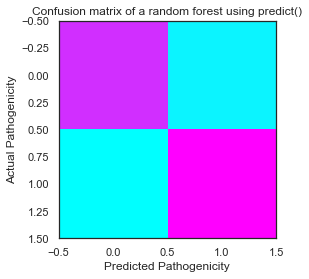

In [159]:
plt.figure()
plt.imshow(confusion, cmap = "cool")
plt.xlabel('Predicted Pathogenicity')
plt.ylabel('Actual Pathogenicity')
plt.title("Confusion matrix of a random forest using predict()");

In [160]:
print(classification_report(y_test, pred, target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       1.00      0.95      0.97        19
         yes       0.96      1.00      0.98        22

    accuracy                           0.98        41
   macro avg       0.98      0.97      0.98        41
weighted avg       0.98      0.98      0.98        41



### Importing full Helix dataset to use the random forest to predict pathogenicity
'pathogenic' = 1 means "unknown," 2 means "yes"

In [50]:
unknown = pd.read_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/numericDF.csv')
print(unknown.pathogenic.value_counts())
unknownDF = unknown[unknown['pathogenic']==1] # filtering for pathogenic status unknown
knownDF = unknown[unknown['pathogenic']==2] # filtering for pathogenic status 'yes' 
print(unknownDF.pathogenic.value_counts())
print(knownDF.pathogenic.value_counts())

1    13522
2      846
Name: pathogenic, dtype: int64
1    13522
Name: pathogenic, dtype: int64
2    846
Name: pathogenic, dtype: int64


In [51]:
X = unknownDF.drop(['base', 'gene', 'pathogenic'], axis = 1)
X.head(5)

,annotation,counts_hom,counts_het,mutation
0,8,0,2,2
1,8,0,1,2
2,8,0,2,2
3,8,0,2,2
4,8,1,0,3


In [52]:
unbiased_rnd_clf = RandomForestClassifier(random_state=0, ccp_alpha= 0.03)
sampleDF = unknownDF.sample(n=846)
balancedDF = pd.concat([sampleDF, knownDF])
X_train, X_test, y_train, y_test = train_test_split(balancedDF.drop(['base', 'gene', 'pathogenic'], axis = 1),
                                                        balancedDF.loc[:, 'pathogenic'], test_size=0.25)
unbiased_rnd_clf.fit(X_train, y_train) # train the classifier
y_pred = unbiased_rnd_clf.predict(X_test)
        
score="{:.2f}".format(accuracy_score(y_test, y_pred)) # add accuracy score to the scores array
print(score)

0.69


In [53]:
preds = unbiased_rnd_clf.predict(X)
print(np.count_nonzero(preds == 2))
print(np.count_nonzero(preds == 1))

2284
11238


### Joining predictions to original dataframe

In [54]:
predDF = unknownDF.drop(['pathogenic'], axis = 1)
predDF['prediction'] = pd.Series(preds)
#predDF.insert(6, "prediction", preds)
print(predDF.prediction.value_counts())
predDF.head(5)
predDF.to_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/rndPredDF1.csv')

1.0    10536
2.0     2163
Name: prediction, dtype: int64


# Random Forest Predicts 11029 non-pathogenic variants and 1670 pathogenic variants among "unknown" bases
#### This is the result of the initial decision to categorize variants as not pathogenic based on homoplasmic allele frequencies

In [55]:
annotatedDF = pd.read_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/treeDF.csv')
annotatedDF.head(5)

,base,gene,annotation,counts_hom,counts_het,pathogenic,mutation
0,577,MT-TF,tRNA,0,2,unknown,transition
1,580,MT-TF,tRNA,0,1,unknown,transition
2,585,MT-TF,tRNA,0,2,unknown,transition
3,588,MT-TF,tRNA,0,2,unknown,transition
4,591,MT-TF,tRNA,1,0,unknown,transversion


In [56]:
annotatedDF = annotatedDF[annotatedDF['pathogenic']=="unknown"] # filtering for pathogenic status unknown

In [57]:
annotatedDF = annotatedDF.drop(['pathogenic'], axis = 1)
annotatedDF.head(5)

,base,gene,annotation,counts_hom,counts_het,mutation
0,577,MT-TF,tRNA,0,2,transition
1,580,MT-TF,tRNA,0,1,transition
2,585,MT-TF,tRNA,0,2,transition
3,588,MT-TF,tRNA,0,2,transition
4,591,MT-TF,tRNA,1,0,transversion


In [58]:
annotatedDF['prediction'] = pd.Series(preds)
print(annotatedDF.prediction.value_counts())
annotatedDF.head(10)
annotatedDF.to_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/annotatedRndPredDF1.csv')

1.0    10536
2.0     2163
Name: prediction, dtype: int64


### Making no assumptions of non-pathogenicity and building a tree around pathogenic = 'yes' vs. 'unknown'

In [176]:
nonBiasedDF = pd.read_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/labeledHelix.csv')
print(nonBiasedDF.pathogenic.value_counts())
nonBiasedDF.head(5)

yes    846
Name: pathogenic, dtype: int64


,base,gene,allele,annotation,counts_hom,AF_hom,counts_het,AF_het,MM_counts_hom,MM_AF_hom,...,MM_AF_het,pathogenic,helix_feature,mutation,MM_mutation,MM_allele,MM_feature,homoplasmic,heteroplasmic,disease
0,5,MT-CRb,"[""A"",""C""]",NaN,1,0.000005,0,0.000000,NaN,NaN,...,NaN,NaN,non_coding,transversion,NaN,NaN,NaN,NaN,NaN,NaN
1,10,MT-CRb,"[""T"",""C""]",NaN,7,0.000036,1,0.000005,NaN,NaN,...,NaN,NaN,non_coding,transition,NaN,NaN,NaN,NaN,NaN,NaN
2,11,MT-CRb,"[""C"",""T""]",NaN,0,0.000000,1,0.000005,NaN,NaN,...,NaN,NaN,non_coding,transition,NaN,NaN,NaN,NaN,NaN,NaN
3,12,MT-CRb,"[""T"",""C""]",NaN,1,0.000005,0,0.000000,NaN,NaN,...,NaN,NaN,non_coding,transition,NaN,NaN,NaN,NaN,NaN,NaN
4,16,MT-CRb,"[""A"",""T""]",NaN,273,0.001393,4,0.000020,NaN,NaN,...,NaN,NaN,non_coding,transversion,NaN,NaN,NaN,NaN,NaN,NaN


### Being non-biased about pathogenicity: joining the 846 known MitoMap pathogenic instances with random samples of size 846 from variants of unknown status
I'm using the knownDF and unknownDF created above

In [177]:
unknownSample = unknownDF.sample(846)
unknownSample.head(5)

,base,gene,annotation,counts_hom,counts_het,pathogenic,mutation
1920,3357,MT-ND1,3,24,2,1,3
8664,11611,MT-ND4,3,153,11,1,2
10868,14431,MT-ND6,3,16,4,1,2
8055,10730,MT-ND4L,3,6,4,1,2
5112,7612,MT-CO2,3,4,0,1,2


### Combining into splitDF

In [178]:
splitDF = pd.concat([knownDF, unknownSample])
splitDF.pathogenic.value_counts()

2    846
1    846
Name: pathogenic, dtype: int64

### Train-test split

In [179]:
X_train, X_test, y_train, y_test = train_test_split(splitDF.drop(['base', 'gene', 'pathogenic'], axis = 1), splitDF.loc[:, 'pathogenic'], test_size=0.25, random_state=13)

### The test score for unknown vs. yes looks more realistic

In [180]:
split_tree = DecisionTreeClassifier(random_state = 0, min_samples_leaf=20) # increased min samples to avoid crazy overfitting
split_tree.fit(X_train,y_train)
score="{:.2f}".format(split_tree.score(X_test,y_test))
print(score)

0.71


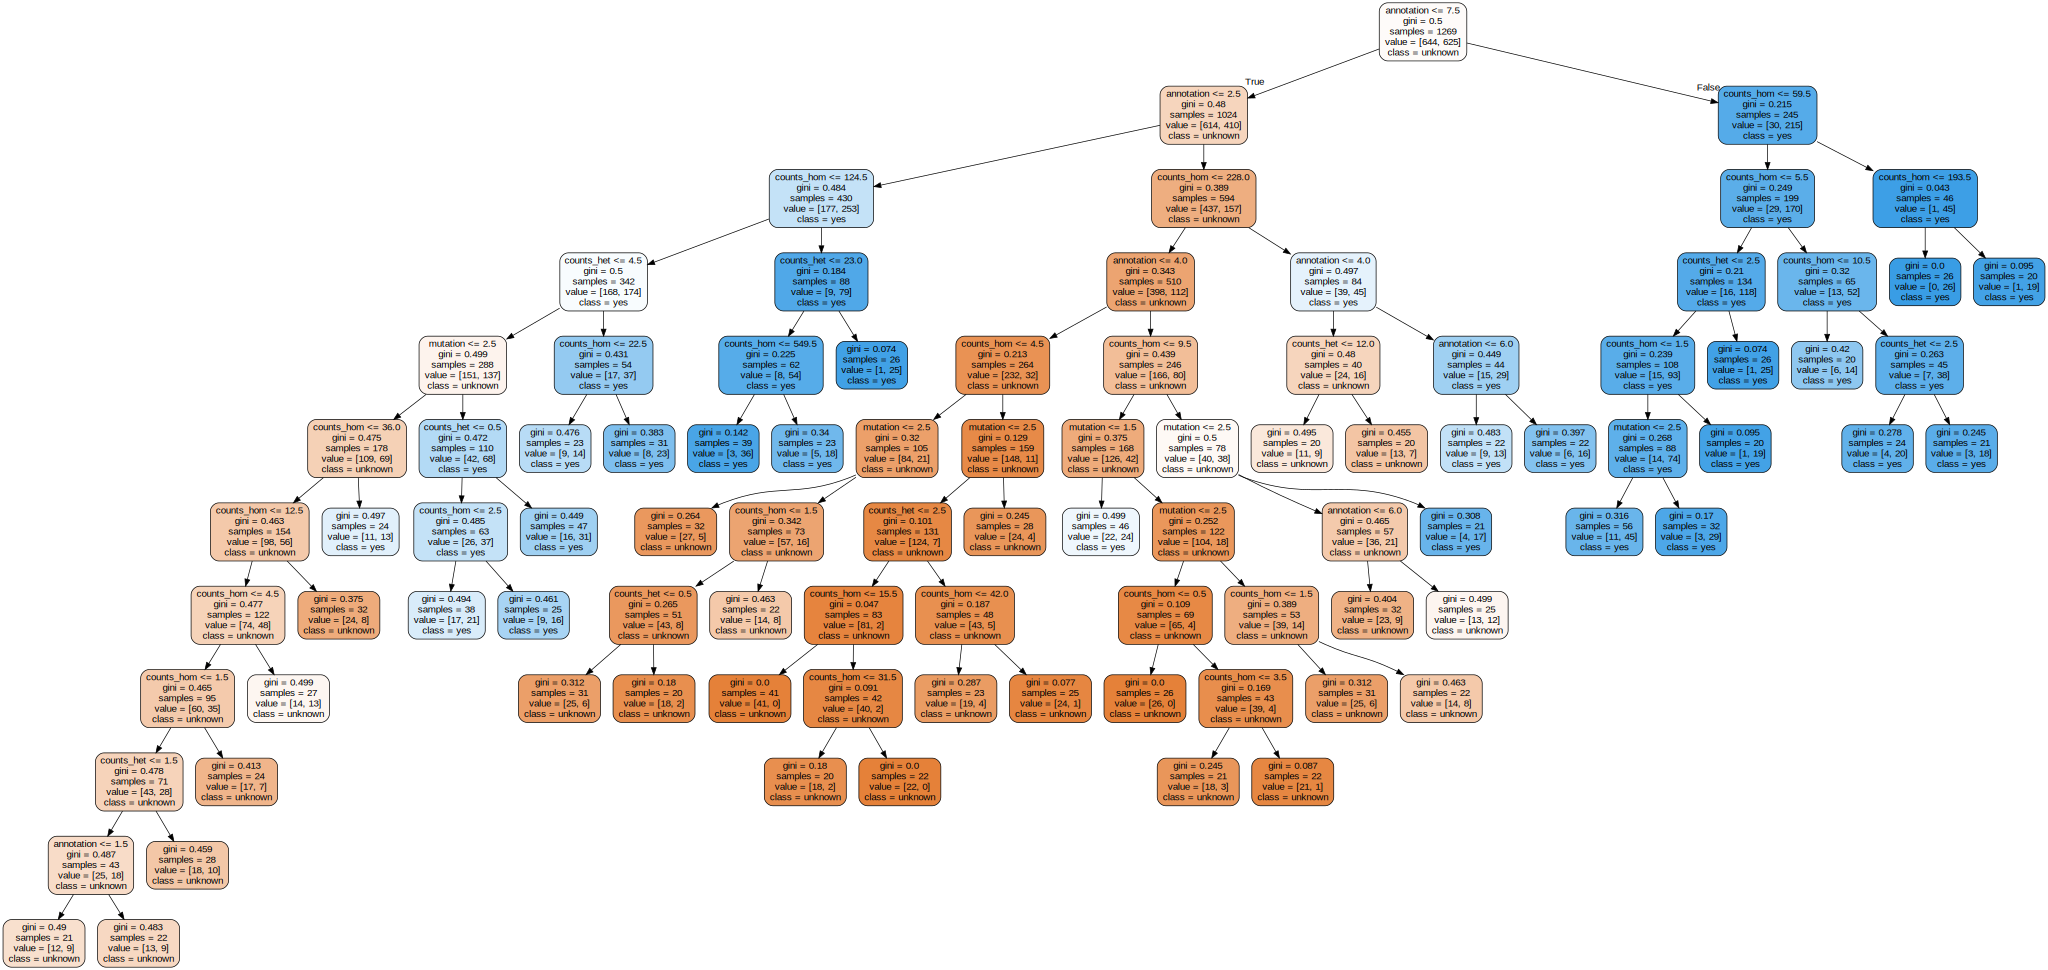

In [181]:
viz = tree.export_graphviz(split_tree,
                                feature_names= X_test.columns,
                                class_names = ['unknown', 'yes'], filled=True, rounded=True)
graph = graphviz.Source(viz, format="png")
graph

In [182]:
graph.render("unbiasedFullTree")

'unbiasedFullTree.png'

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

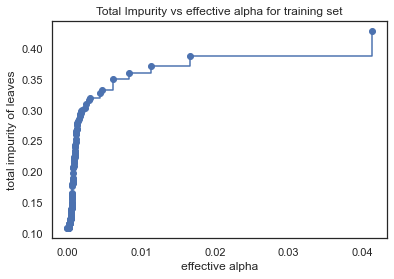

In [183]:
prunedTree = DecisionTreeClassifier(random_state=0)
path = prunedTree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [184]:
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
trees[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.07094169684227475


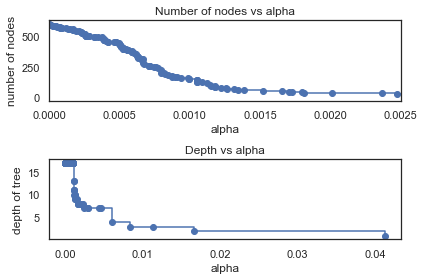

In [185]:
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_xlim(0,0.0025)
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

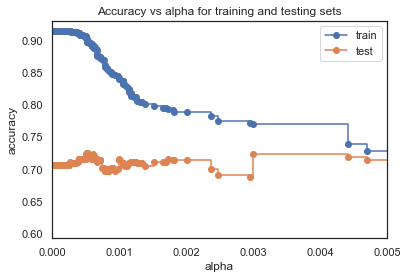

In [186]:
train_scores = [tree.score(X_train, y_train) for tree in trees]
test_scores = [tree.score(X_test, y_test) for tree in trees]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_xlim(0,0.005)
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
drawstyle="steps-post")
ax.legend()
plt.show()

### Looks like an alpha of 0.003 is a good compromise between test accuracy and model complexity but this tree is still much more complex than the one built on the assumptions of allele frequencies

In [190]:
pruned_split_tree = DecisionTreeClassifier(random_state = 0, ccp_alpha=0.003)
pruned_split_tree.fit(X_train,y_train)
score="{:.2f}".format(pruned_split_tree.score(X_test,y_test)) #this is the test score!?
print(score)

0.69


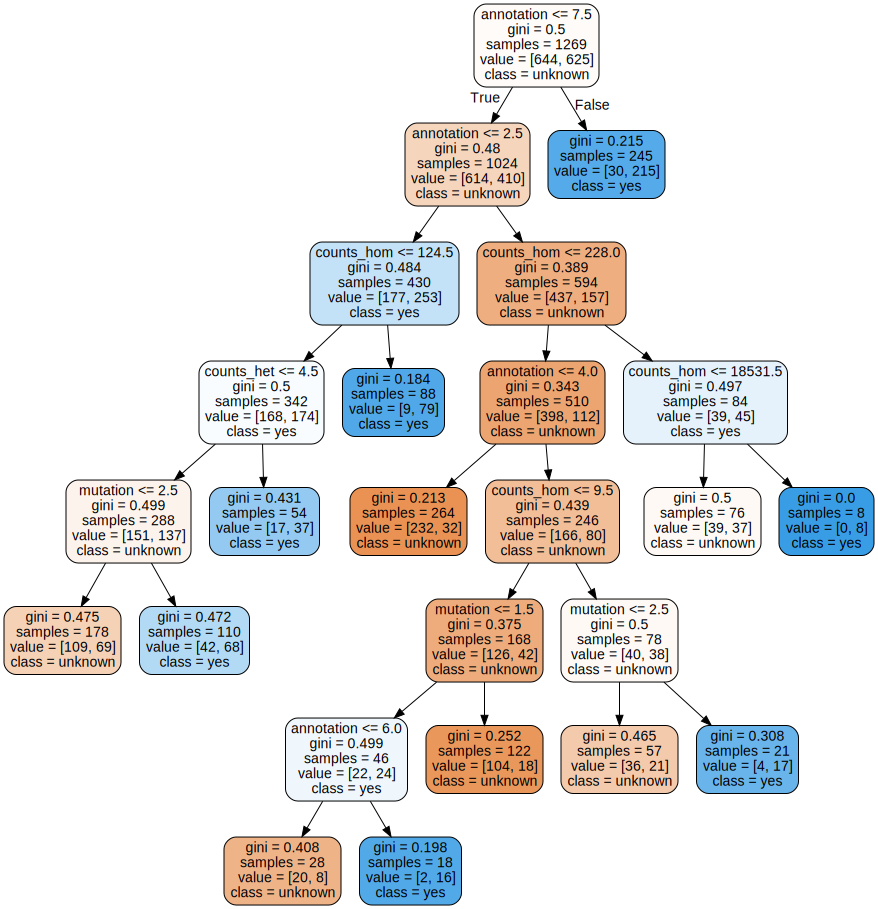

In [191]:
viz = tree.export_graphviz(pruned_split_tree,
                                feature_names= X_test.columns,
                                class_names = ['unknown', 'yes'], filled=True, rounded=True)
graph = graphviz.Source(viz, format="png")
graph

In [192]:
graph.render("pruned_split_tree")

'pruned_split_tree.png'

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


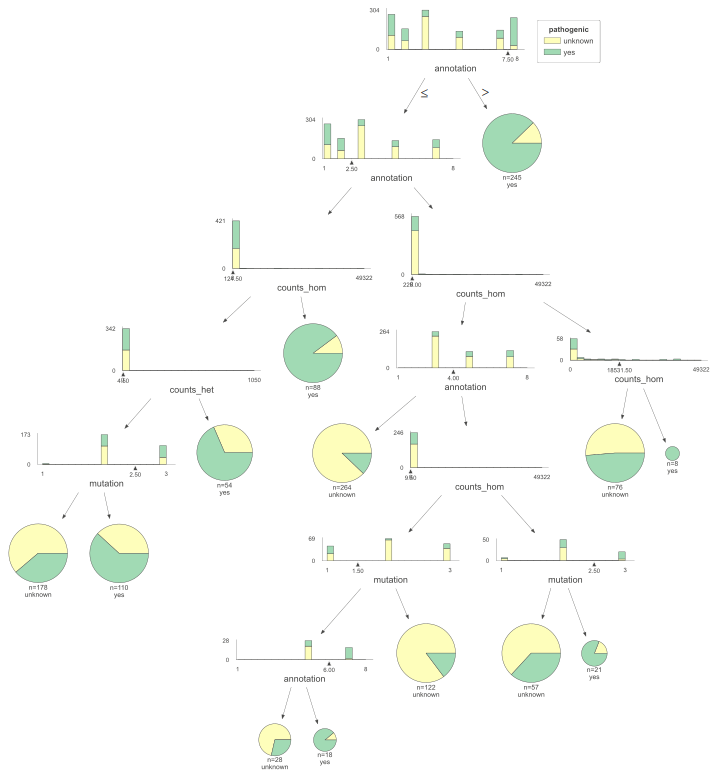

In [193]:
dtviz = dtreeviz(pruned_split_tree, X_train, y_train, target_name="pathogenic", feature_names= X_test.columns,
                class_names=['unknown', 'yes'])
dtviz

In [194]:
dtviz.save("/Users/leekapp/Desktop/CS254/Assignments/FinalProject/prunedSplitTrainTree.svg")

### Testing ensemble methods alongside logistic regression and SVM with 100 replicates and the unbiased DFs
I've based this code on a course in Machine Learning Technologies at the University of Southampton, UK https://tdgunes.com/COMP6246-2019Fall/lab3_solution/index.html
 

In [195]:
def test_clfs(*clfs): # clf -> classifier
    for clf in clfs:
        # making an array to hold the scores
        accuracy_scores = np.zeros(100, dtype = float)
        
        # making new train-test splits from balanced DFs sampled original yes/no DFs
        for i in range(100):
            sampleDF = unknownDF.sample(n=846) #  adjusting number to sample variants of unknown status
            balancedDF = pd.concat([sampleDF, knownDF])
            X_train, X_test, y_train, y_test = train_test_split(balancedDF.drop(['base', 'gene', 'pathogenic'], axis = 1),
                                                        balancedDF.loc[:, 'pathogenic'], test_size=0.25)
            clf.fit(X_train, y_train) # train the classifier
            y_pred = clf.predict(X_test)
        
            score="{:.2f}".format(accuracy_score(y_test, y_pred)) # add accuracy score to the scores array
            accuracy_scores[i] = score
 
        print(clf.__class__.__name__ + "  Mean Accuracy:","{:.2f}".format(accuracy_scores.mean()), 
        clf.__class__.__name__ + "  Std dev:", "{:.2f}".format(accuracy_scores.std(ddof=1)))

### Using cost-complexity pruning in random forest as with individual tree, alpha = 0.003 and a hard voting classifier

In [198]:
log_clf = LogisticRegression(solver='liblinear', max_iter=100, random_state=0)
rnd_clf = RandomForestClassifier(random_state=0, ccp_alpha= 0.003)
svm_clf = SVC(random_state=0, probability=True)
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard') # hard voting
test_clfs(log_clf, rnd_clf, svm_clf, voting_clf)

LogisticRegression  Mean Accuracy: 0.61 LogisticRegression  Std dev: 0.02
RandomForestClassifier  Mean Accuracy: 0.75 RandomForestClassifier  Std dev: 0.02
SVC  Mean Accuracy: 0.54 SVC  Std dev: 0.03
VotingClassifier  Mean Accuracy: 0.69 VotingClassifier  Std dev: 0.02


### Random forest classifier has highest accuracy: confusion matrix

         unknown  yes
unknown      125   77
yes           66  155


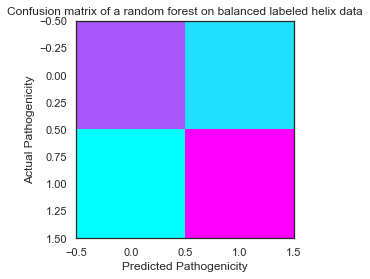

In [199]:
pred = cross_val_predict(rnd_clf, X_test, y_test)
confusion_matrix(y_test, pred)
confusion = pd.DataFrame(confusion_matrix(y_test, pred), index = ['unknown', 'yes'],
                         columns = ['unknown', 'yes'])
print(confusion)
plt.figure()
plt.imshow(confusion, cmap = "cool")
plt.xlabel('Predicted Pathogenicity')
plt.ylabel('Actual Pathogenicity')
plt.title("Confusion matrix of a random forest on balanced labeled helix data");

In [200]:
print(classification_report(y_test, pred, target_names=['unknown', 'yes']))

              precision    recall  f1-score   support

     unknown       0.65      0.62      0.64       202
         yes       0.67      0.70      0.68       221

    accuracy                           0.66       423
   macro avg       0.66      0.66      0.66       423
weighted avg       0.66      0.66      0.66       423



In [201]:
rnd_clf.feature_importances_

array([0.55921929, 0.20666617, 0.15170937, 0.08240518])

### Using a random forest to predict status for all unknown variants

In [30]:
# re-import the data
unknown = pd.read_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/numericDF.csv')
print(unknown.pathogenic.value_counts())
unknownDF = unknown[unknown['pathogenic']==1] # filtering for pathogenic status unknown
knownDF = unknown[unknown['pathogenic']==2] # filtering for pathogenic status 'yes'

1    13522
2      846
Name: pathogenic, dtype: int64


In [31]:
split_rnd_clf = RandomForestClassifier(random_state=0, ccp_alpha= 0.003)
X = unknownDF.drop(['base', 'gene', 'pathogenic'], axis = 1)
X.head(5)

,annotation,counts_hom,counts_het,mutation
0,8,0,2,2
1,8,0,1,2
2,8,0,2,2
3,8,0,2,2
4,8,1,0,3


In [32]:
sampleDF = unknownDF.sample(n=846) #  adjusting number to sample variants of unknown status
balancedDF = pd.concat([sampleDF, knownDF])
X_train, X_test, y_train, y_test = train_test_split(balancedDF.drop(['base', 'gene', 'pathogenic'], axis = 1),
                                                        balancedDF.loc[:, 'pathogenic'], test_size=0.25)
split_rnd_clf.fit(X_train, y_train) # train the classifier
y_pred = split_rnd_clf.predict(X_test)

score="{:.2f}".format(accuracy_score(y_test, y_pred)) # add accuracy score to the scores array

 
print(score)

0.74


In [33]:
preds = split_rnd_clf.predict(X)

In [34]:
print(np.count_nonzero(preds == 2)) #3444 pathogenic mutations predicted
print(np.count_nonzero(preds == 1)) #10078 non-pathogenic mutations preducted

3444
10078


### Joining predictions to the  unknownDF used to generate the samples of unknown variants to train the classifier

In [37]:
unknown = pd.read_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/numericDF.csv')
print(unknown.pathogenic.value_counts())
unknownDF = unknown[unknown['pathogenic']==1] # filtering for pathogenic status unknown
knownDF = unknown[unknown['pathogenic']==2] # filtering for pathogenic status 'yes'

1    13522
2      846
Name: pathogenic, dtype: int64


In [38]:
# re-import the data
predDF = unknownDF.drop('pathogenic', axis=1)
predDF['prediction'] = pd.Series(preds)
predDF.head(5)

,base,gene,annotation,counts_hom,counts_het,mutation,prediction
0,577,MT-TF,8,0,2,2,2.0
1,580,MT-TF,8,0,1,2,2.0
2,585,MT-TF,8,0,2,2,2.0
3,588,MT-TF,8,0,2,2,2.0
4,591,MT-TF,8,1,0,3,2.0


In [46]:
predDF.prediction.value_counts()

1.0    9461
2.0    3238
Name: prediction, dtype: int64

### Have to join this to knownDF for completely annotatedDF

In [221]:
predDF.head(5)

,base,gene,annotation,counts_hom,counts_het,mutation,prediction
0,577,MT-TF,8,0,2,2,2
1,580,MT-TF,8,0,1,2,2
2,585,MT-TF,8,0,2,2,2
3,588,MT-TF,8,0,2,2,2
4,591,MT-TF,8,1,0,3,2


In [222]:
knownDF.head(5)

,base,gene,annotation,counts_hom,counts_het,pathogenic,mutation
8,593,MT-TF,8,480,41,2,2
9,593,MT-TF,8,86,0,2,1
10,593,MT-TF,8,9,0,2,3
11,593,MT-TF,8,37,3,2,3
24,606,MT-TF,8,1,0,2,3


### Have to rename 'prediction' to 'pathogenic' before combining data frames

In [223]:
predDF.rename(columns={'prediction':'pathogenic'},inplace=True)

In [224]:
predictedDF = pd.concat([predDF, knownDF])

In [229]:
print(predictedDF.pathogenic.value_counts())
predictedDF.head(5)

1    10528
2     3840
Name: pathogenic, dtype: int64


,base,gene,annotation,counts_hom,counts_het,mutation,pathogenic
0,577,MT-TF,8,0,2,2,2
1,580,MT-TF,8,0,1,2,2
2,585,MT-TF,8,0,2,2,2
3,588,MT-TF,8,0,2,2,2
4,591,MT-TF,8,1,0,3,2


In [228]:
predictedDF.to_csv("/Users/leekapp/Desktop/CS254/Assignments/FinalProject/predictedDF.csv")

In [47]:
annotatedDF = pd.read_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/treeDF.csv')
annotatedUKDF = annotatedDF[annotatedDF['pathogenic']=="unknown"] # filtering for pathogenic status ='unknown'
annotatedUKDF.head(5)

,base,gene,annotation,counts_hom,counts_het,pathogenic,mutation
0,577,MT-TF,tRNA,0,2,unknown,transition
1,580,MT-TF,tRNA,0,1,unknown,transition
2,585,MT-TF,tRNA,0,2,unknown,transition
3,588,MT-TF,tRNA,0,2,unknown,transition
4,591,MT-TF,tRNA,1,0,unknown,transversion


In [49]:
annotatedDF['prediction'] = pd.Series(preds)
print(annotatedDF.prediction.value_counts())
annotatedDF.head(10)
annotatedDF.to_csv('/Users/leekapp/Desktop/CS254/Assignments/FinalProject/annotatedRndPredDF2.csv')

1.0    10078
2.0     3444
Name: prediction, dtype: int64


### Repeating comparison of classification methods with log transformed counts

In [233]:
treeDF = numericDF.drop(columns = ['counts_hom', 'counts_het'])
treeDF.head(5)

,base,gene,annotation,pathogenic,mutation,log_hom,log_het
0,593,MT-TF,8,2,2,6.173786,3.713572
1,593,MT-TF,8,2,1,4.454347,-6.907755
2,593,MT-TF,8,2,3,2.197225,-6.907755
3,593,MT-TF,8,2,3,3.610918,1.098612
4,606,MT-TF,8,2,3,0.000000,-6.907755


In [242]:
### making a new DF where 'pathogenic' == 'yes'
yesDF = treeDF[treeDF['pathogenic']==2]
print('Yes: ', yesDF.pathogenic.value_counts())

###extracting the rows where 'pathogenic' == 'no'
noDF = treeDF[treeDF['pathogenic']==1]
print('No: ', noDF.pathogenic.value_counts())

Yes:  2    852
Name: pathogenic, dtype: int64
No:  1    82
Name: pathogenic, dtype: int64


In [244]:
yesDF.head(5)

,base,gene,annotation,pathogenic,mutation,log_hom,log_het
0,593,MT-TF,8,2,2,6.173786,3.713572
1,593,MT-TF,8,2,1,4.454347,-6.907755
2,593,MT-TF,8,2,3,2.197225,-6.907755
3,593,MT-TF,8,2,3,3.610918,1.098612
4,606,MT-TF,8,2,3,0.000000,-6.907755


In [249]:
def test_clfs(*clfs): # clf -> classifier
    for clf in clfs:
        # making an array to hold the scores
        accuracy_scores = np.zeros(100, dtype = float)
        
        # making new train-test splits from balanced DFs sampled original yes/no DFs
        for i in range(100):
            sampleDF = yesDF.sample(n=82) #  adjusting number to sample variants of unknown status
            balancedDF = pd.concat([sampleDF, noDF])
            X_train, X_test, y_train, y_test = train_test_split(balancedDF.drop(['base', 'gene', 'pathogenic'], axis = 1),
                                                        balancedDF.loc[:, 'pathogenic'], test_size=0.25)
            clf.fit(X_train, y_train) # train the classifier
            y_pred = clf.predict(X_test)
        
            score="{:.2f}".format(accuracy_score(y_test, y_pred)) # add accuracy score to the scores array
            accuracy_scores[i] = score
 
        print(clf.__class__.__name__ + "  Mean Accuracy:","{:.2f}".format(accuracy_scores.mean()), 
        clf.__class__.__name__ + "  Std dev:", "{:.2f}".format(accuracy_scores.std(ddof=1)))

In [250]:
log_clf = LogisticRegression(solver='liblinear', max_iter=100, random_state=0)
tree_clf= DecisionTreeClassifier(random_state = 0, ccp_alpha=0.03)
rnd_clf = RandomForestClassifier(random_state=0, ccp_alpha= 0.03)
svm_clf = SVC(random_state=0, probability=True)
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard') # hard voting
test_clfs(log_clf, tree_clf, rnd_clf, svm_clf, voting_clf)

LogisticRegression  Mean Accuracy: 0.78 LogisticRegression  Std dev: 0.06
DecisionTreeClassifier  Mean Accuracy: 0.89 DecisionTreeClassifier  Std dev: 0.07
RandomForestClassifier  Mean Accuracy: 0.92 RandomForestClassifier  Std dev: 0.05
SVC  Mean Accuracy: 0.88 SVC  Std dev: 0.05
VotingClassifier  Mean Accuracy: 0.89 VotingClassifier  Std dev: 0.05


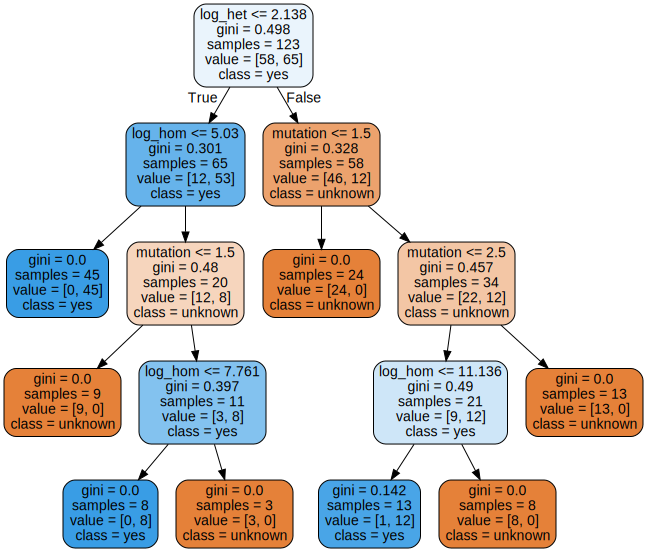

In [258]:
colLables = yesDF.drop(columns= ['gene', 'base', 'pathogenic'])
viz = tree.export_graphviz(tree_clf,
                                feature_names= colLables.columns,
                                class_names = ['unknown', 'yes'], filled=True, rounded=True)
graph = graphviz.Source(viz, format="png")
graph

In [259]:
graph.render("log_based_tree")

'log_based_tree.png'